# Convolutional neural networks (CNN)

Convolutional Neural Networks (ConvNets or CNNs) are  Neural Networks with a certain structure that have proven very effective in areas such as image recognition and classification. 

In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torch import nn, optim
from time import time
#Allows showing plots in notebook:
%matplotlib inline
from torchvision import datasets, transforms
#import imageio

### Getting the data - identical data set and steps that we did in the previous lesson

In [2]:
np.random.seed(42) # For reproducebility


In [3]:
# transform for data normalization
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# transforms.ToTensor() — converts the image into numbers, that are understandable by the system. It separates the image into three color channels (separate images): red, green & blue. Then it converts the pixels of each image to the brightness of their color between 0 and 255. These values are then scaled down to a range between 0 and 1. The image is now a Torch Tensor.
# transforms.Normalize() — normalizes the tensor with a mean and standard deviation which goes as the two parameters respectively.

#The  numbers 0.5 that are passed to the transform are the mean and the STD that will normalize each image
#image = (image - mean) / std



In [4]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [5]:
print('the number of images in the train set:', len(trainset))
print('the number of images in the validation/test set:', len(valset))

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

the number of images in the train set: 60000
the number of images in the validation/test set: 10000
torch.Size([64, 1, 28, 28])
torch.Size([64])


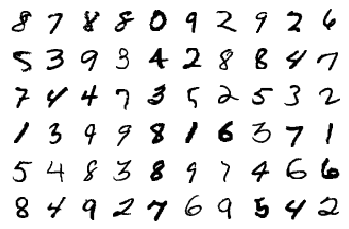

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### define network structure in pytorch 
If you want to learn more see these pytorch tutorials - [1](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), [2](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)


A typical training procedure for a neural network:

- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient

## Using a convolutional NN

In [18]:
class cnn_net(nn.Module):
    def __init__(self):
        super(cnn_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() #regularization method to prevent overfitting. 
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         print(x.shape)
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
#         print(x.shape)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) #regularization method to prevent overfitting.  - will be discussed later
        x = self.fc2(x)
        return F.log_softmax(x)

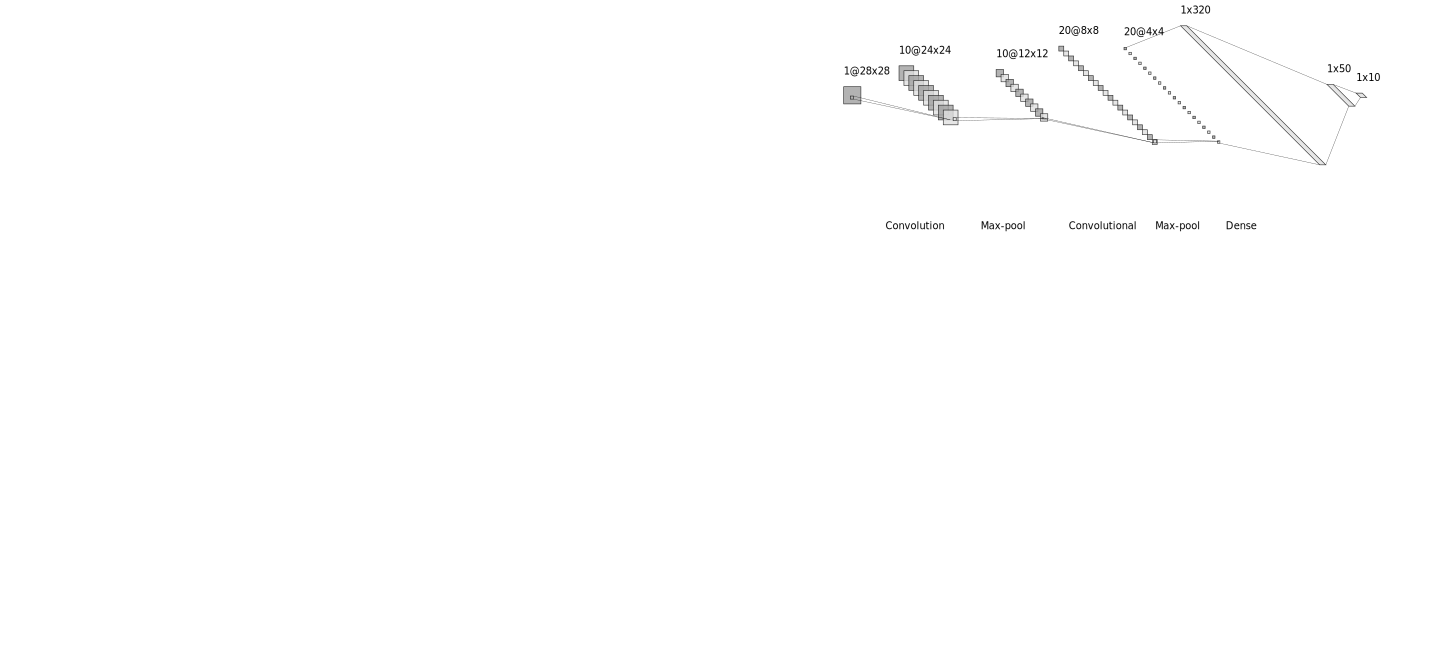

In [2]:
# The plot was created using this website: http://alexlenail.me/ (ALEXANDER LENAIL - MIT PhD student)
from IPython.display import SVG, display
display(SVG('figs/CNN.svg'))

### Convolution

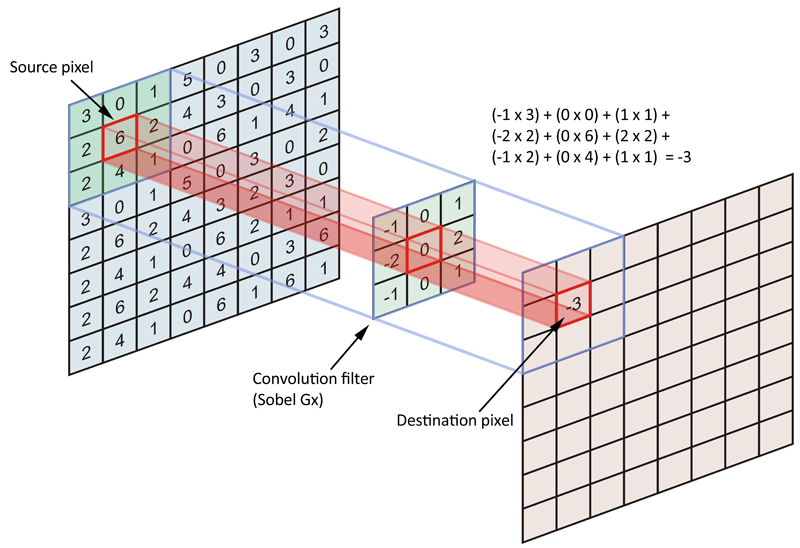

In [6]:
from IPython.display import Image
Image(filename='figs/Convolution_explained.png', width=500) #Source of figure - https://datascience.stackexchange.com/questions/23183/why-convolutions-always-use-odd-numbers-as-filter-size

See also [here](https://algorithmia.com/blog/convolutional-neural-nets-in-pytorch) a great visualization of convolution

### max Pooling layer

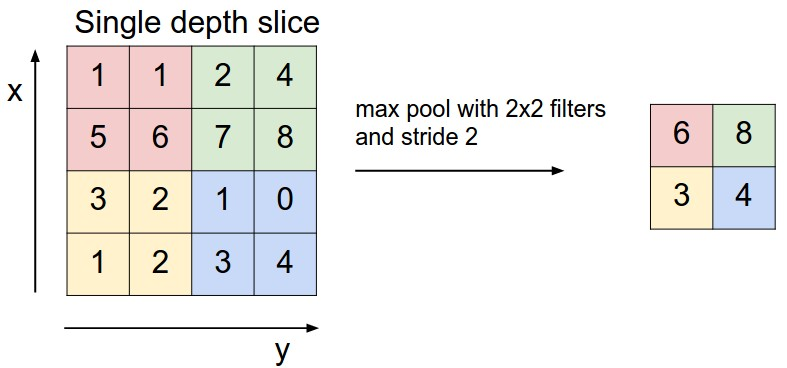

In [7]:
#Image taken from: http://cs231n.github.io/convolutional-networks/
Image(filename='figs/maxpool.jpeg', width=700)



This is just one simple architecture - see other example and great explenations about CNN's here http://cs231n.github.io/convolutional-networks/


In [22]:
log_interval = 100
learning_rate = 0.01
momentum = 0.5

In [23]:
network = cnn_net()
# optimizer = optim.SGD(network.parameters(), lr=learning_rate,
#                       momentum=momentum)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
criterion = nn.NLLLoss() # Negative log liklihood loss function

In [24]:
test_loader =valloader
train_loader = trainloader

In [25]:
n_epochs = 4
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

### Defining function for the training procedure - similar to previous lesson!

In [26]:
def train_CNN(net,criterion,optimizer,epoch,trainloader):
    net.train() # When using dropout this is necessary! it states that we are on a training mode.
    for batch_idx, (data, target) in enumerate(trainloader):
        # gradient has to be manually set to zero because otherwise gradients are accumulated
        optimizer.zero_grad()
        # Calculates the output for some bach of figures
        output = net(data)
        # Calculates the loss
        loss = criterion(output, target)
        # This is where gradients are calculated (for the loss tensor)
        loss.backward()
        #And optimizes its weights here by some gradient decent like scheme
        optimizer.step()
        #Just to print how the progress is doing:
        if batch_idx % log_interval == 0:
            if batch_idx > 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))


### Defining function for testing

In [27]:
def test_CNN(net,criterion,testloader,batchsize=64,nsamples=10000):
    net.eval() # basically states that we are in evaluation mode. When using dropout necessary!
    test_loss = 0
    correct = 0
    flag_size = 0
    with torch.no_grad():
#     for data, target in testloader:
        for i, (data, target) in enumerate(testloader):
            output = net(data) # get predictions
            test_loss += criterion(output, target).item() # Sum over the losses 
            pred = output.data.max(1, keepdim=True)[1] # Get label with maximum probability
            correct += pred.eq(target.data.view_as(pred)).sum() #Comparing the true labels to the predicted labels
            if i*batchsize > nsamples: 
                flag_size = 1
                break
    if flag_size == 1:
        max_len = i*batchsize
    else:
        max_len = len(testloader.dataset)
    test_loss /= max_len
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, max_len,
    100. * correct / max_len))

In [28]:
n_epochs = 2 #Number of epocs
time0 = time()  
for epoch in range(1, n_epochs + 1):
    train_CNN(network,criterion,optimizer,epoch,trainloader)
    print("\nTraining Time for one epoch (in minutes) =",(time()-time0)/60)
    print('Performance on the train set:')
    test_CNN(network,criterion,trainloader)
    print('Performance on the test set:')
    test_CNN(network,criterion,valloader)

/Users/yani/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.305013
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.477581
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.521009
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.127907
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.175088
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.082275
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.249240
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.528313
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.141959

Training Time for one epoch (in minutes) = 0.4457724690437317
Performance on the train set:

Test set: Avg. loss: 0.0012, Accuracy: 9905/10048 (99%)

Performance on the test set:

Test set: Avg. loss: 0.0011, Accuracy: 9800/10000 (98%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.212421
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.082042
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.514427
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.290950
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.193656
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.198802
Train Epoch: 2

NO improvement after 1 epoch - Probably need to reduce the learning rate!

There are better schemes for the learning rate (I recommend the fastai course that suggest a scheme that starts with a very small learning rate, which is increased, and from some point is decreased again. 

In [29]:
learning_rate = 0.001
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [30]:
n_epochs2 = 2
for epoch in range(1, n_epochs + 1):
    train_CNN(network,criterion,optimizer,epoch,trainloader)
    print("\nTraining Time for one epoch (in minutes) =",(time()-time0)/60)
    print('Performance on the train set:')
    test_CNN(network,criterion,trainloader)
    print('Performance on the test set:')
    test_CNN(network,criterion,valloader)

/Users/yani/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.169325
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.145969
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.036569
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.054274
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.185747
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.385767
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.181763
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.077383
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.116008

Training Time for one epoch (in minutes) = 1.6272707859675088
Performance on the train set:

Test set: Avg. loss: 0.0005, Accuracy: 10006/10048 (100%)

Performance on the test set:

Test set: Avg. loss: 0.0007, Accuracy: 9885/10000 (99%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.108866
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.016886
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.178575
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.143580
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.201935
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.087617
Train Epoch:

Generally, CNN is very helpful if there is translational invariance in the data. 

For results of the MNIST datasets from different papers and methods - see https://paperswithcode.com/sota/image-classification-on-mnist

/Users/yani/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


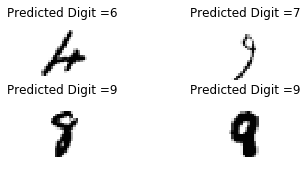

In [32]:
num_stop = 3
num_now =0 
for images,labels in valloader:
    if num_now > num_stop:
        break
    for i in range(len(labels)):
        if num_now > num_stop:
            break
        with torch.no_grad():
            img = images[i].unsqueeze(0)
            logps = network(img)

    
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label != pred_label):
            num_now = num_now + 1
            plt.subplot(num_stop, 2, num_now)
            plt.axis('off')
            plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
            title1 = 'Predicted Digit =' +str(probab.index(max(probab)))
            plt.title(title1)
#             plt.title('my random fig') 





### Number of parameters in convolutional layer

See (https://medium.com/@iamvarman/how-to-calculate-the-number-of-parameters-in-the-cnn-5bd55364d7ca)

Consider a convolutional layer which takes “l” feature maps as the input and has “k” feature maps as output. The filter size is “n*m”.
Here the input has l=32 feature maps as inputs, k=64 feature maps as outputs and filter size is n=3 and m=3. It is important to understand, that we don’t simply have a $3*3$ filter, but actually, we have $3*3*32$ filter, as our input has 32 dimensions. And as an output from first conv layer, we learn 64 different $3*3*32$ filters which total weights is $n*m*k*l$. Then there is a term called bias for each feature map. So, the total number of parameters are $(n*m*l+1)*k$.

# Normalizing Inputs

Normalizing the inputs speed up the training of a neural network.
For more reading (https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

## BatchNormalization 

Normalize the activation values such that the hidden representation doesn’t vary drastically and also helps us to get improvement in the training speed.

The batch of RGB images has four dimensions — batch_size x channels x height x width. In the case of images, we normalize the batch over each channel. The class BatchNorm2d applies batch normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension).

In [35]:
class cnn_net_bn(nn.Module):
    def __init__(self):
        super(cnn_net_bn, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() #regularization method to prevent overfitting. 
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
#         print(x.shape)
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.bn2(self.conv2(x))), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
#         print(x.shape)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [39]:
learning_rate = 0.003
cnnBN = cnn_net_bn()
optimizer = optim.Adam(cnnBN.parameters(), lr=learning_rate)
n_epochs = 2 #Number of epocs
time0 = time()  
for epoch in range(1, n_epochs + 1):
    train_CNN(cnnBN,criterion,optimizer,epoch,trainloader)
    print("\nTraining Time for one epoch (in minutes) =",(time()-time0)/60)
    print('Performance on the train set:')
    test_CNN(cnnBN,criterion,trainloader)
    print('Performance on the test set:')
    test_CNN(cnnBN,criterion,valloader)

/Users/yani/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.324523
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.284569
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.128900
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.259311
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.195952
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.126679
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.314891
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.642585
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.104480

Training Time for one epoch (in minutes) = 0.5634334325790405
Performance on the train set:

Test set: Avg. loss: 0.0009, Accuracy: 9957/10048 (99%)

Performance on the test set:

Test set: Avg. loss: 0.0009, Accuracy: 9825/10000 (98%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.205719
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.198570
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.311808
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.078066
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.061903
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.123251
Train Epoch: 2

In [40]:
optimizer = optim.Adam(cnnBN.parameters(), lr=learning_rate/10)
n_epochs = 2 #Number of epocs
time0 = time()  
for epoch in range(1, n_epochs + 1):
    train_CNN(cnnBN,criterion,optimizer,epoch,trainloader)
    print("\nTraining Time for one epoch (in minutes) =",(time()-time0)/60)
    print('Performance on the train set:')
    test_CNN(cnnBN,criterion,trainloader)
    print('Performance on the test set:')
    test_CNN(cnnBN,criterion,valloader)

/Users/yani/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.129643
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.174031
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.042190
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.040281
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.061055
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.017543
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.012786
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.090124
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.067045

Training Time for one epoch (in minutes) = 0.5761671702067057
Performance on the train set:

Test set: Avg. loss: 0.0004, Accuracy: 10035/10048 (100%)

Performance on the test set:

Test set: Avg. loss: 0.0004, Accuracy: 9908/10000 (99%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.040268
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.043020
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.156018
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.068979
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.063276
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.143725
Train Epoch:

Try to add your own batch normalization

# Regularization of Neural Networks

- weight decay (added in the optimizer part - see ?optim.Adam)
- Dropout (added in the definition of the network). 
- Data augmentation
- Early stopping

#### Weight decay

weight decay is usually defined as a term that’s added directly to the update rule.
Namely, to update a certain weight $w$ in the $i+1$ iteration, we would use a modified rule:

$w_{i+1}$ = w_{i} - \gamma (A w_{i} + \frac{\partial L}{\partial w})

In practice, this is almost identical to L_2 regularization, though there is some difference (e.g., see [here](https://bbabenko.github.io/weight-decay/))

Weight decay is one of the parameters of the optimizer - try ?torch.optim.SGD

#### Dropout

By dropping a unit out, we mean temporarily removing it from the network while training, along with all its incoming and outgoing connections. 
See more details [here](http://jmlr.org/papers/v15/srivastava14a.html)

?nn.Dropout2d